Purpose: Run hierarchical clustering of treatments from log2 TPM data corrected for BioProject using pyComBat (both the full dataset & photosynthetic tissues only).<br>
Author: Anna Pardo<br>
Date initiated: Feb. 29, 2024

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import statistics

In [2]:
# load corrected TPM matrices
bpcor_all_tpm = pd.read_csv("../../data/BioProject_pyComBat_TPM_29-Feb-2024.tsv",sep="\t",header="infer")

In [3]:
bpcor_psyn_tpm = pd.read_csv("../../data/psyn_tissues_tpm_combatBioProject.tsv",sep="\t",header="infer")

In [5]:
bpcor_psyn_tpm.head()

,Sample,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,3.676968,1.425305,0.019366,3.454238,2.464770,3.181359,0.480547,-0.043836,1.148040,...,0.197235,-0.007364,0.004322,-0.000069,-0.025771,0.197944,-0.006917,0.030309,-0.000506,0.127112
1,SRR11933272,4.041835,1.692175,0.546391,2.778114,1.452964,1.410374,0.260699,-0.043836,1.765632,...,0.130296,0.118151,0.004322,-0.000069,-0.025771,2.373048,-0.006917,0.030309,-0.000506,0.127112
2,SRR11933250,3.221863,1.653241,-0.054140,1.886622,1.731918,3.663976,0.074623,-0.043836,1.594690,...,0.006349,-0.007364,0.004322,-0.000069,-0.025771,0.295277,-0.006917,0.303918,-0.000506,1.162604
3,SRR11933029,3.091750,1.449443,-0.054140,1.367097,1.463797,3.913553,0.074623,-0.043836,1.446212,...,0.006349,-0.007364,0.004322,-0.000069,-0.025771,-0.133042,-0.006917,0.030309,-0.000506,1.251770
4,SRR11933040,3.411677,1.593612,-0.054140,1.138459,2.108122,3.921366,0.233557,-0.043836,1.758469,...,0.204556,0.005240,0.004322,-0.000069,-0.025771,2.767788,-0.006917,0.030309,-0.000506,1.703918


In [6]:
# load metadata
md = pd.read_csv("../../data/metadata_corrected_14-Feb-2024.csv",sep=",",header="infer")

In [7]:
# merge with metadata
psyn_merged = bpcor_psyn_tpm.merge(md[["Sample","Treatment"]],how="inner")
psyn_merged.drop("Sample",axis=1,inplace=True)
psyn_merged.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Treatment
0,3.676968,1.425305,0.019366,3.454238,2.464770,3.181359,0.480547,-0.043836,1.148040,-0.014533,...,-0.007364,0.004322,-0.000069,-0.025771,0.197944,-0.006917,0.030309,-0.000506,0.127112,Drought
1,4.041835,1.692175,0.546391,2.778114,1.452964,1.410374,0.260699,-0.043836,1.765632,-0.014533,...,0.118151,0.004322,-0.000069,-0.025771,2.373048,-0.006917,0.030309,-0.000506,0.127112,Drought
2,3.221863,1.653241,-0.054140,1.886622,1.731918,3.663976,0.074623,-0.043836,1.594690,-0.014533,...,-0.007364,0.004322,-0.000069,-0.025771,0.295277,-0.006917,0.303918,-0.000506,1.162604,Drought
3,3.091750,1.449443,-0.054140,1.367097,1.463797,3.913553,0.074623,-0.043836,1.446212,-0.014533,...,-0.007364,0.004322,-0.000069,-0.025771,-0.133042,-0.006917,0.030309,-0.000506,1.251770,Control
4,3.411677,1.593612,-0.054140,1.138459,2.108122,3.921366,0.233557,-0.043836,1.758469,-0.014533,...,0.005240,0.004322,-0.000069,-0.025771,2.767788,-0.006917,0.030309,-0.000506,1.703918,Drought


In [8]:
# rename DroughtRepeat to Drought
psyn_merged["Treatment"].mask(psyn_merged["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [9]:
# group by treatment and calculate the mean
hcd = psyn_merged.groupby(by="Treatment",axis=0).mean()

In [11]:
# run hierarchical clustering
h = linkage(hcd,"ward")

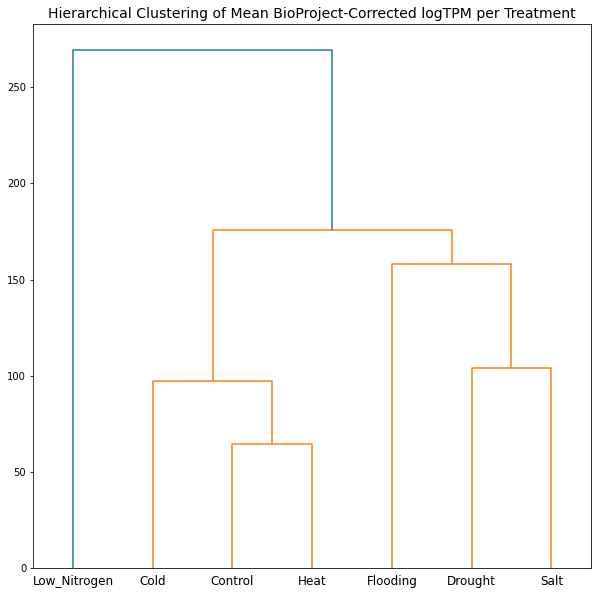

In [12]:
# plot dendrogram: non-pyComBat data
plt.figure(figsize=(10,10))
dendrogram(h,labels=hcd.index)
plt.title("Hierarchical Clustering of Mean BioProject-Corrected logTPM per Treatment",fontsize=14)
#plt.savefig("../../figures/PCA/hclust_treatments_mean.pdf")
plt.show()